In [1]:
import torch
from torch.utils.data import DataLoader
from utils import Encoder
from pytorch_lightning.callbacks import RichProgressBar
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from object_detection_models import MultiClassJetNet
from object_detection_data import SyntheticData


In [2]:
image_width = 80
image_height = 60

default_scalings = torch.tensor([[0.25, 0.25]])
num_classes = 1
encoder = Encoder(default_scalings, num_classes)

torch.manual_seed(2)
train_data = SyntheticData(image_width, image_height, 10000, encoder)
val_data = SyntheticData(image_width, image_height, 1000, encoder)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="synthetic_data_logs/")


pl_model = MultiClassJetNet(encoder, 1e-3)
trainer = pl.Trainer(
    limit_predict_batches=100,
    max_epochs=20,
    callbacks=[RichProgressBar()],
    logger=tb_logger,
)
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: synthetic_data_logs/lightning_logs


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ accuracy            │ MulticlassAccuracy │      0 │
│ 1 │ input_layer         │ NormConv2dReLU     │    146 │
│ 2 │ depth_wise_backbone │ Sequential         │  4.9 K │
│ 3 │ classifier          │ Sequential         │ 20.9 K │
│ 4 │ output_layer        │ Conv2d             │    150 │
└───┴─────────────────────┴────────────────────┴────────┘

Trainable params: 26.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.1 K                                                                                               
Total estimated model params size (MB): 0

2023-03-07 15:34:42.322120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:34:42.481638: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 15:34:43.176610: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 15:34:43.176674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Output()

/home/jonathan/hulks/ml/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:22
4: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/jonathan/hulks/ml/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:22
4: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=20` reached.


In [51]:
import utils

num_classes = 1
threshold = 0.5
for batch in train_loader:
    image, encoded_target_boxes, target_is_object, encoded_target_classes = batch
    encoded_predicted_boxes, predicted_class_logits = pl_model(image)
    encoded_predicted_classes = calculate_predicted_classes(predicted_class_logits)
    predicted_boxes, predicted_classes = encoder.decode_model_output(
        encoded_predicted_boxes, encoded_predicted_classes
    )
    target_boxes, target_classes = encoder.decode_model_output(
        encoded_target_boxes, encoded_target_classes.flatten()
    )

    mean_average_precision = utils.mean_average_precision(
        predicted_boxes,
        predicted_classes,
        target_boxes,
        target_classes,
        threshold,
        num_classes,
    )

    break
mean_average_precision

tensor(1.)

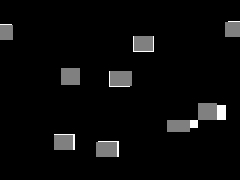

In [8]:
from visualize import draw_model_output, image_grid
import utils


grid_size = 3
image_list = []
for i in range(grid_size * grid_size):
    image, encoded_bounding_boxes, target_masks, encoded_target_classes = train_data[i]
    predicted_boxes, predicted_class_logits = pl_model(image.unsqueeze(0))
    predicted_classes = utils.calculate_predicted_classes(predicted_class_logits).squeeze()
    decoded_boxes = encoder.decode_bounding_boxes(predicted_boxes).squeeze()

    image_list.append(
        draw_model_output(
            image,
            decoded_boxes,
            predicted_classes,
            torch.tensor([0, 1]),
        )
    )
image_grid(image_list, grid_size, grid_size)
